<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Pipeline Tutorial SWDB 2018 </h1> 
<h3 align="center">Wednesday, August 29, 2018</h3> 

# Feature engineering & model selection with Scikit-Learn pipelines

In this tutorial, you will learn

- How to use the AllenSDK to extract population response vectors from Natural Scenes
- How to use scikit-learn "Pipeline" to chain together multiple steps in a decoding analysis
- How to cross-validate your pipeline
- How to search hyperparameters to optimize your model

This tutorial is going to work through building a model to decode the identity of natural scenes from the population activty of neurons in an experiment from the Allen Brain Observatory.

Let's get started.

First, we are going to import the `BrainObservatoryCache` from the allensdk.

In [1]:
from __future__ import print_function
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

boc = BrainObservatoryCache()

Next, we will load up a single experiment with Natural Scenes

In [2]:
experiment_id = 541206592
dataset = boc.get_ophys_experiment_data(experiment_id)
metadata = dataset.get_metadata()
print(metadata['targeted_structure'])
print(metadata['imaging_depth_um'])
print(metadata['cre_line'])

VISp
350
Scnn1a-Tg3-Cre/wt


To decode the identity of individual image presentations from the population activity, we need the following

- `y` - vector of integers, where each integer corresponds to a natural scene
- `X` - array of floats, where each column is the activity of a single neuron in response to a given natural scene presentation. Each row of this array is often called a "population vector"

The process of getting to `X` from raw data (in this case, the continuous activity of a population of neurons) is known as "feature engineering". This involves multiple decisions, including whether to use dF/F or inferred spike events, whether to take the mean or peak of the response (or other metrics), and over what window relative to events to compute these metrics.

For this tutorial, we will take advantage of the `NaturalScenes` object in the AllenSDK to make these decisions for us.

In [3]:
from allensdk.brain_observatory.natural_scenes import NaturalScenes
ns = NaturalScenes(dataset)

### Getting "y" from the natural scenes stim_table

Each image presentation occupies a row in the `.stim_table` attribute of the `NaturalScenes` object

In [4]:
images = ns.stim_table.copy()
images.head()

,frame,start,end
0,92,16125,16132
1,27,16133,16140
2,52,16140,16147
3,37,16148,16155
4,103,16155,16162


Conveniently, the 'frame' column has integer labels of each natural scene. We define `y` from this column.

In [5]:
y = images['frame']

### Getting "X" from the natural scenes mean_sweep_response

Each row in the `.mean_sweep_response` attribute corresponds to the mean activity of each neuron in the recorded population in response to each image presentation in the stim table.

In [6]:
X = ns.mean_sweep_response.copy()
X.drop('dx',axis=1,inplace=True)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
0,2.750398,3.113332,3.283231,1.035660,2.312769,1.005320,1.795959,1.302906,1.109441,2.644591,...,3.245388,1.204343,3.223873,-0.614828,1.594057,2.538169,9.322724,3.246232,17.838305,44.883263
1,5.472741,4.520462,1.848134,1.509070,3.900594,2.375818,0.627758,0.452645,-1.946570,-0.088816,...,5.051270,3.157544,2.147983,3.462305,1.155841,3.599893,10.790494,3.700325,41.864319,55.052734
2,4.938696,1.872071,0.822514,-0.366550,0.590227,0.577107,-0.431362,3.239566,-2.953792,0.519713,...,0.117338,2.204452,0.433436,1.692538,4.946897,-2.181524,1.229501,1.446858,19.081219,-0.731454
3,0.686303,-1.502568,-2.128904,-0.779033,-3.098761,0.632175,2.272473,4.147108,-4.235024,-0.116484,...,-3.436971,1.661621,-1.256703,0.234285,5.248888,-1.481765,-3.012385,0.283391,-6.771274,-18.988461
4,-2.763241,-2.317277,-1.518564,-1.131271,-3.716857,0.189942,1.049816,0.004382,-3.942320,-2.070535,...,-3.320092,0.768980,0.713630,4.319497,1.107409,0.044746,-4.763652,-0.807627,-15.687251,-24.453199


## Splitting into train & test sets

Now that we have `X` and `y`, we're going to split the data into a training set, which we will explore and use to develop a decoding pipeline, and a test set, which we will hold out until we are happy with our pipeline, to do a final evaluation of it's performance.

In [7]:
# split training & testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, 
    stratify=y, # this makes sure that our training and testing sets both have all classes in y
)

## Train a classifier

First, we are going to train a classifier and use cross validation to evaluate it's performance on our training data.

In [8]:
# do the classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
classifier = LinearDiscriminantAnalysis()

In [9]:
from sklearn.model_selection import cross_val_score

In [10]:
scores = cross_val_score(classifier, X_train, y_train, cv=5)

/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


In [11]:
import numpy as np
scores.mean() * len(np.unique(y_train))

17.249999999999996

## Reduce the dimensionality of the data
Next, we are going to reduct the dimensionality of the data, then train our classifier on the reduced data.

In [12]:
from sklearn.decomposition import PCA
reducer = PCA(n_components=20)

In [13]:
X_reduced = reducer.fit_transform(X_train)
print(X.shape, X_reduced.shape)

(5950, 154) (4760, 20)


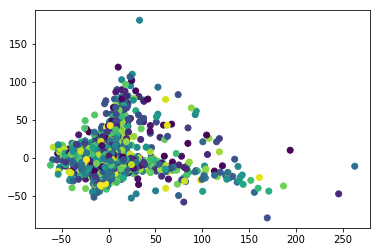

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(X_reduced[:,0],X_reduced[:,1],c=y_train)

In [15]:
scores = cross_val_score(classifier, X_reduced, y_train, cv=5)
scores.mean() * len(np.unique(y))

/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


10.1

## Rescale the data to zero mean and unit variance first

Our dimensionality reduction and classification is likely dominated by neurons with very large responses. Let's rescale the data first.

In [16]:
from sklearn.preprocessing import StandardScaler
rescaler = StandardScaler()

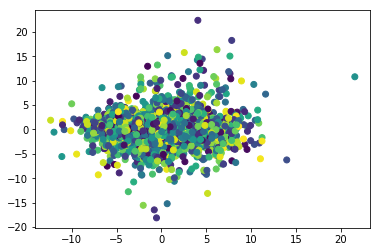

In [17]:
X_rescaled = rescaler.fit_transform(X_train)
X_reduced = reducer.fit_transform(X_rescaled)
plt.scatter(X_reduced[:,0],X_reduced[:,1],c=y_train)

In [18]:
scores = cross_val_score(classifier, X_reduced, y_train, cv=5)
scores.mean() * len(np.unique(y_train))

/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


13.325000000000001

## Assemble these steps into a Pipeline

We now have 3 steps in our processing pipeline... rescaling, reducing, and classifying. Keeping track of these steps and their intermediate variables can get confusing.

Luckily, since each of these steps use objects that conform to the scikit-learn fit/transform/predict standard, we can use the scikit learn pipeline module to assemble them into a pipeline, which itself has fit & predict methods, so it can drop into functions like `cross_val_score`.


In [19]:
from sklearn.pipeline import Pipeline

In [20]:
pipeline = Pipeline((
    ('rescaler', StandardScaler()),
    ('reducer', PCA(n_components=20)),
    ('classifier', LinearDiscriminantAnalysis()),
))

In [21]:
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
scores.mean() * len(np.unique(y))

/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


12.674999999999999

## Optimizing the pipeline

Now that we've defined a pipeline, we can more readily adjust parts of the pipeline to improve it... adjust the parameters for each step, remove steps, replace one classifier with another. These pieces of an ML pipeline are aften referred to as "hyperparameters".

If we want to do this exploration strategically, we can search over this space to select the best hyperparameters. One way to do this is with scikit-learn's `GridSearchCV`. This lets us do the following....

- specify a set of parameters we want to search over
- for each combination of parameters, do an n-fold cross validation
- rank the parameter combinations based on their average cross validation performance

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


N_FEATURES_OPTIONS = [20, 40, 80,]

param_grid = [
    {
        'rescaler': [None, StandardScaler()],
        'reducer__n_components': N_FEATURES_OPTIONS,
        'classifier': [
            LinearDiscriminantAnalysis(),
            KNeighborsClassifier(n_neighbors=50),
            DecisionTreeClassifier(),
        ]
    },
]

In [23]:
grid = GridSearchCV(pipeline, param_grid)

In [24]:
grid.fit(X_train, y_train)
grid.best_estimator_

/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do

Pipeline(memory=None,
     steps=[('rescaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reducer', PCA(copy=True, iterated_power='auto', n_components=80, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))])

## Let's visualize the cross validation results

In [25]:
import pandas as pd
cv_results = pd.DataFrame(grid.cv_results_)

/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/justink/anaconda3/envs/allensdk/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

In [26]:
cv_results['param_rescaler'] = ~pd.isnull(cv_results['param_rescaler'])

In [27]:
cv_results['param_classifier'] = cv_results['param_classifier'].map(lambda x: str(x).split('(')[0])

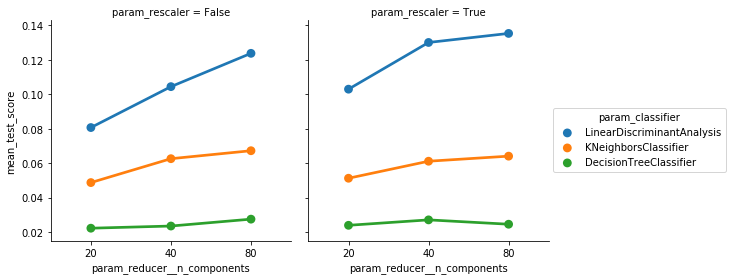

In [28]:
import seaborn as sns
sns.factorplot('param_reducer__n_components','mean_test_score',data=cv_results,
               hue='param_classifier',
               col='param_rescaler',
              )

## Evaluate the selected model on the held out test data

The `GridSearchCV` instance itself has the scikit-learn predict & score methods. When called, they use the "best estimator" that was identified during the fitting step.

So now we can use the score method to evaluate the model on the held out test data.

In [29]:
grid.score(X_test, y_test) * len(np.unique(y))

17.8